
# Model eigenvalues  

Eigenvalues are a fundamental concept in dynamic models. In simple terms, they summarize the adjustment process within a model. In the context of dynamic models, the sign and magnitude of the eigenvalues determine whether a system of equations will converge to a stable equilibrium, oscillate, or diverge. 

In the case of a macromodel, which is effectively a system of differential equations, the eigenvalues of the coefficient matrix determine whether the system is stable, marginally stable, or unstable. If all the eigenvalues have negative real parts, then the system is stable and will converge to a steady state over time. If at least one eigenvalue has a positive real part, then the system is unstable, and the solutions will diverge over time.


The modelflow library includes a range of methods to calculate the eigenvalues of a model, which can be used to help to assure that a model's dynamics will be stable and to identify sources of instability where they exist.

In [1]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')


In [2]:
# Prepare the notebook for use of modelflow 

# Jupyter magic command to improve the display of charts in the Notebook
%matplotlib inline

# Import pandas 
import pandas as pd

# Import the model class from the modelclass module 
from modelclass import model 

# functions that improve rendering of modelflow outputs
model.widescreen()
model.scroll_off();

<IPython.core.display.Javascript object>

In [3]:
# Import to handle imaginary numbers 
import numpy as np 

# Import of modelflow lineraization methods. 
from modelnewton import newton_diff

## Load a pre-existing model, data and descriptions 

For the purposes of this exposition the climate aware model forPakistan described {cite:author}`burns_climate_2021` is used.



In [4]:
mpak,baseline = model.modelload('../models/pak.pcim')
baseline = mpak(baseline,2023,2024)


file read:  C:\modelflow manual\papers\mfbook\content\models\pak.pcim


:::{index} single: modelflow; .newtondiff() method
:::

:::{index} single: model derivatives
:::

:::{index} single: eigenvalues
:::

:::{index} single: modelflow; eigenvalues
:::
## the method .newton_diff()

The `modelflow` method `.newtondiff()` calculates the derivatives of the mpak model, and in the code block belows assigne the results to the object mpak_newton.


In [5]:
mpak_newton = newton_diff(mpak,forcenum=0)      # create a newton_diff instance which contains derivatives 

:::{index} single: eigenvalyues; .get_eigenvalues() method
:::
:::{index} single: modelflow; .get_eigenvalues() method
:::

### .get_eigenvalues method
The get_eigenvectors function calculates the actual eigenvectors of the model.  For a large model this can be a fairly time consuming calculation taking several minutes even on relatively powerful multicore i9 computers.

:::{index} single: modelflow; .get_eigplot_all() method
:::
:::{index} single: eqigenvalues; .get_eigplot_all() method
:::
Once the eigenvalues are calculated they can be displayed graphically with the `.eigplot_all()` method.

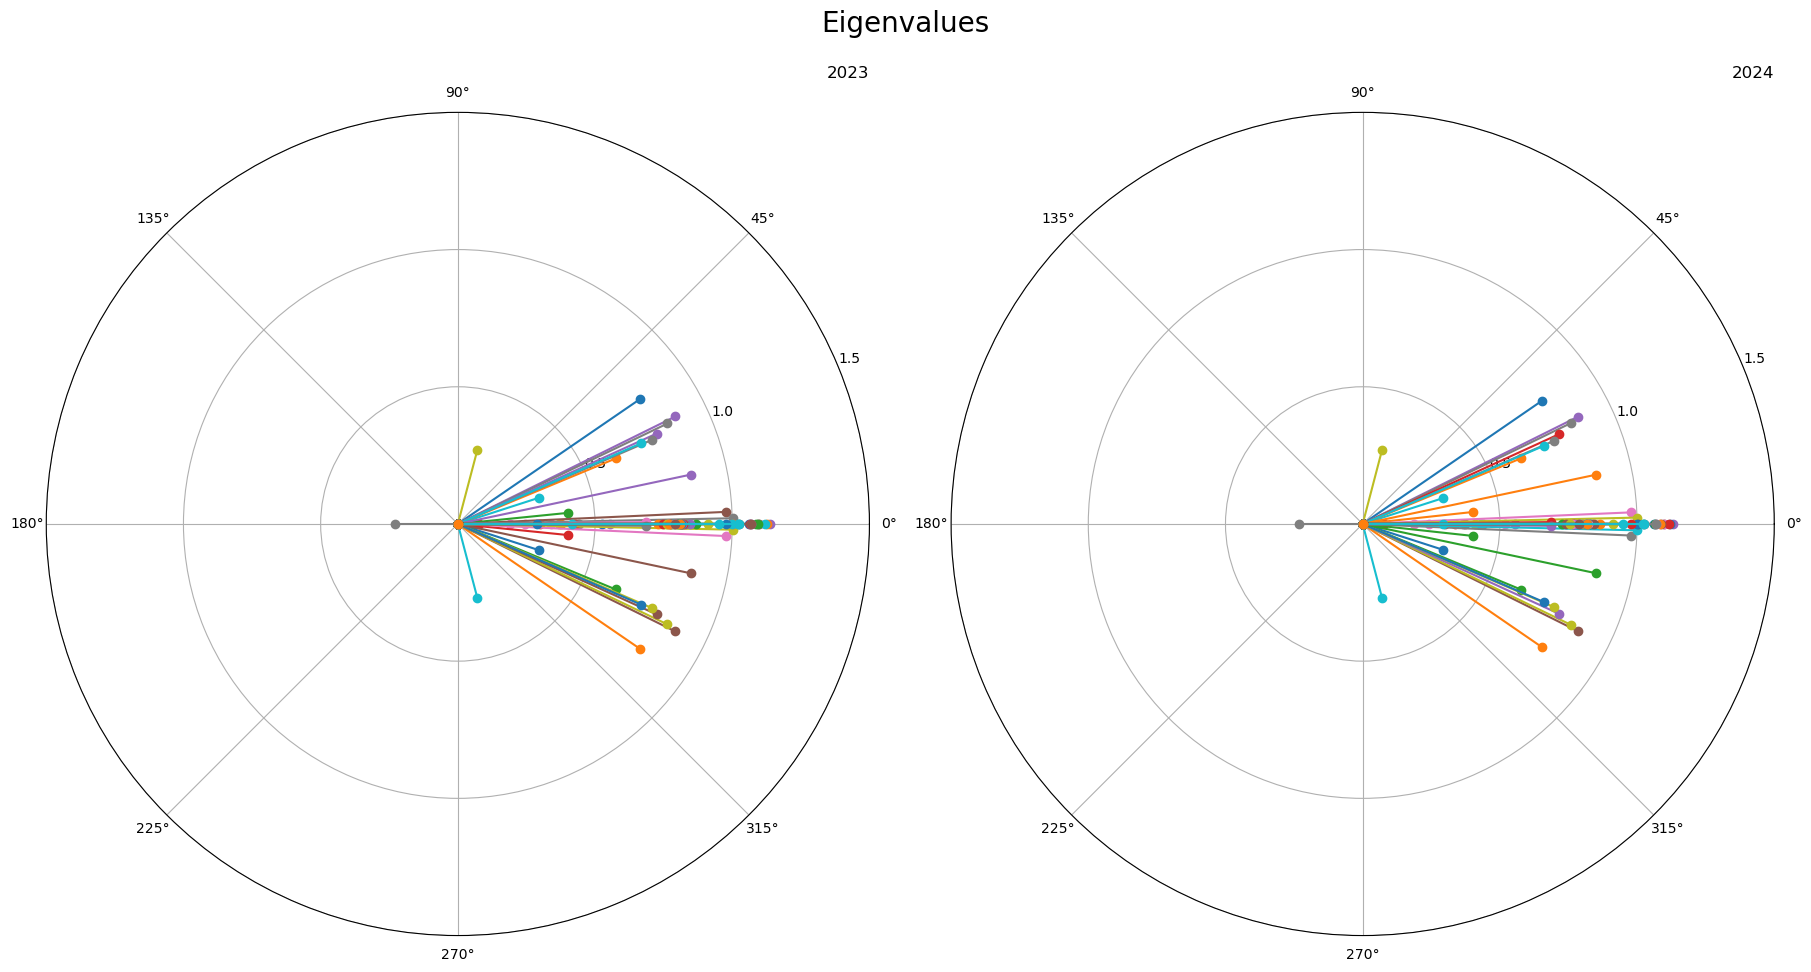

In [6]:
eig_dic = mpak_newton.get_eigenvectors(filnan = True,periode= (2023,2024),silent=False,asdf=1) #  
mpak_newton.eigplot_all(eig_dic,size=(3,3));

### Isolating potentially problematic eigenvalues

In the charts above it is clear that the vast majority of eigenvalues lie within the real unit circle, implying that the associated equations are dynamically stable.  However, there are several that lie outside of the unit circle.

The code below identifies and prints out those elements that are greater than one.

In [7]:
eigen = eig_dic[2023]
gt1_no_imag = sorted([(ii,i)  for ii,i in enumerate(eigen) if abs(i) >= 1 and abs(i.imag) < 0.0000000001],reverse=True)
gt1_imag    = sorted([(ii,i)  for ii,i in enumerate(eigen) if np.abs(i) >= 1 and np.abs(i.imag) >  0.00000001],reverse=True)

print('Eigenvalues with length above 1 and only real: ')
print(*[f'element {ii} length: {abs(i):.5f} ' for ii,i in gt1_no_imag],'  ',sep='\n')
print('Eigenvalues with length above 1 and imaginary: ')
print(*[f'element {ii} length: {abs(i):.5f} {i.real:.5f} {i.imag:.5f}' for ii,i in gt1_imag],sep='\n')



Eigenvalues with length above 1 and only real: 
element 1499 length: 1.02441 
element 1419 length: 1.02000 
element 1329 length: 1.00000 
element 1325 length: 1.06952 
element 1324 length: 1.06998 
element 1323 length: 1.06368 
element 1322 length: 1.08554 
element 1321 length: 1.00287 
element 1320 length: 1.06036 
element 1312 length: 1.09349 
element 1309 length: 1.12010 
element 1301 length: 1.12521 
element 535 length: 1.00816 
element 495 length: 1.02299 
element 494 length: 1.13663 
element 456 length: 1.09513 
element 455 length: 1.09868 
  
Eigenvalues with length above 1 and imaginary: 
element 1318 length: 1.00303 1.00282 -0.02085
element 1317 length: 1.00303 1.00282 0.02085


These results that 16 eigenvalues exceed 1 and that two exceed one and have imaginary roots.

## Dealing with potential instability

Unfortunately there is no one-to-one relationship between equations and eigenvalues. It may be that certain equations are inherently unstable, error-correction models where the speed of adjustment is greater than one for example.  Equation results can be inspected for such sources of instability.  

Other sources of instability may be more subtle and lie in the interaction of coefficients across equations.  One approach to identifying potentially problematic equations is to perform a grid-search by recalculating the eigenvalues of the system after eliminating one at a time individual equations. The elimination of an ill-formed equation is likely to cause large and greater than one eigenvalues to shrink and potentially even fall within the unit circle.

:::{index} single: stability; .get_eigen_jackknife_abs_select() method
:::
:::{index} single: eigenvalues; .get_eigen_jackknife_abs_select() method
:::
:::{index} single: modelflow; .get_eigen_jackknife_abs_select() method
:::


### The `.get_eigen_jackknife_abs_select()` method

Modelflow includes a jackknife algorithm (`.get_eigen_jackknife_abs_select()`) that systematically drops one-by-one each equation from model, and then recalculates the eigenavlues of the smaller model.  By keeping track of the  size of the largest eigenvalues, it seeks to identify one (or more) equations that have a large influence on the eigenvalues of the system.

For a large model, this can be a time-consuming exercise (7-12 minutes for mpak, depending on the user's processor). 

In the example below `.get_eigen_jackknife_abs_select()` is called for the year 2023, and with the parameters `maxnames=500`, which limits the number of equations that will be tested to 500, and `largest=40`, which causes the method to return a dataframe comprised of the sum of the eigenvalues of  largest 20 eigenvalues.



To test code, the parameter maxnames can be set to restrict the number of re-samplings.

The routine sums the 20 largest eigenvalues each time an equation is omitted.  Equations whose omission from the model reduces the largest eigenvalues the most are most likely to be the source of model instability.


Calculating eigenvalues of 303 different matrices takes time, so make cup of coffee and a take a short nap


PAKBXGSRGNFSCD_excluded   16.9632962055875
PAKNECONGOVTCN_excluded   16.9696625024298
PAKNEGDIFGOVCN_excluded   16.9795787171142
PAKBMGSRMRCHCD_excluded   17.0012431636151
PAKNYGDPFCSTXN_excluded   17.0040812053491
ALL                       17.0968933585011
PAKGGEXPTOTLCN_excluded   17.1665358813480
PAKNYGDPGAP__excluded     17.1680895238997
PAKNYGDPMKTPKN_excluded   17.1925216447922
PAKNECONOTHRXN_excluded   17.2469134953761
PAKNECONPRVTXN_excluded   17.3269614213803
dtype: float64

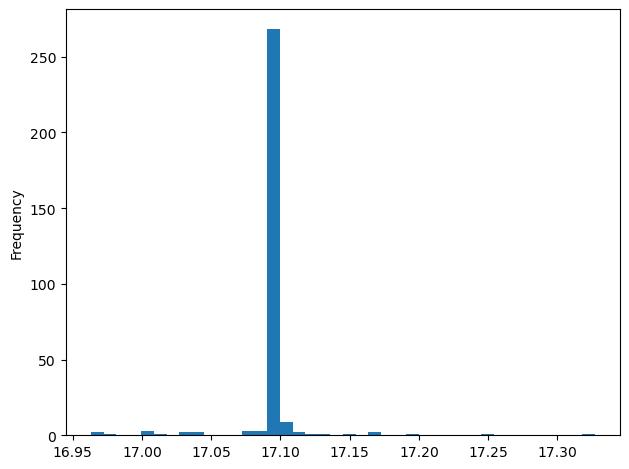

In [8]:

pd.set_option('display.float_format', '{:.13f}'.format) 
xx = mpak_newton.get_eigen_jackknife_abs_select(2023,maxnames=500,largest = 16)
xx.plot(kind='hist',bins=40)
pd.concat([xx.head(),xx.loc[['ALL']],xx.tail()])

the histogram reports the values of the sum of the 16 largest eigenvalues (the number in the original model that exceeded 1) in each of the 303 sets of eigenvalues calculated. For the vast majority (about 275 of 303) of equations their elimination had no appreciable impact on the sum of the top 16 eigenvalues.  However size equations reduced eigenvalues by .05 or more.



In [9]:

xx.sort_values(ascending=True).head(16)



PAKBXGSRGNFSCD_excluded   16.9632962055875
PAKNECONGOVTCN_excluded   16.9696625024298
PAKNEGDIFGOVCN_excluded   16.9795787171142
PAKBMGSRMRCHCD_excluded   17.0012431636151
PAKNYGDPFCSTXN_excluded   17.0040812053491
PAKBMGSRGNFSCD_excluded   17.0048007205016
PAKNVGASPRODXN_excluded   17.0144221977496
PAKNECONENGYXN_excluded   17.0298583099564
PAKNVCOLPRODXN_excluded   17.0304443643904
PAKNVOILPRODXN_excluded   17.0365765927920
PAKNVRENPRODXN_excluded   17.0395485643110
PAKXMKT_excluded          17.0755194502371
PAKBXGSRMRCHCD_excluded   17.0769418105505
PAKCFVOLUMECN_excluded    17.0799269988700
PAKNYWRTTOTLCN_excluded   17.0883524362332
PAKPSTAR_excluded         17.0889671479873
dtype: float64

In [10]:
xx = mpak_newton.get_eigenvectors(filnan = True,periode= (2023,2024),silent=False,asdf=1,dropvar=['PAKBXGSRGNFSCD','PAKNECONGOVTCN','PAKNEGDIFGOVCN','PAKBMGSRMRCHCD','PAKBMGSRGNFSCD','PAKNYGDPFCSTXN','PAKNVGASPRODXN','PAKNECONPRVTKN','PAKNYWRTTOTLCN','PAKNYWRTINFMCN','PAKNECONENGYXN','PAKNVCOLPRODXN','PAKNYYWBTOTLCN','PAKPSTAR','PAKNYWRTFORMCN','PAKNECONPRVTCN'])

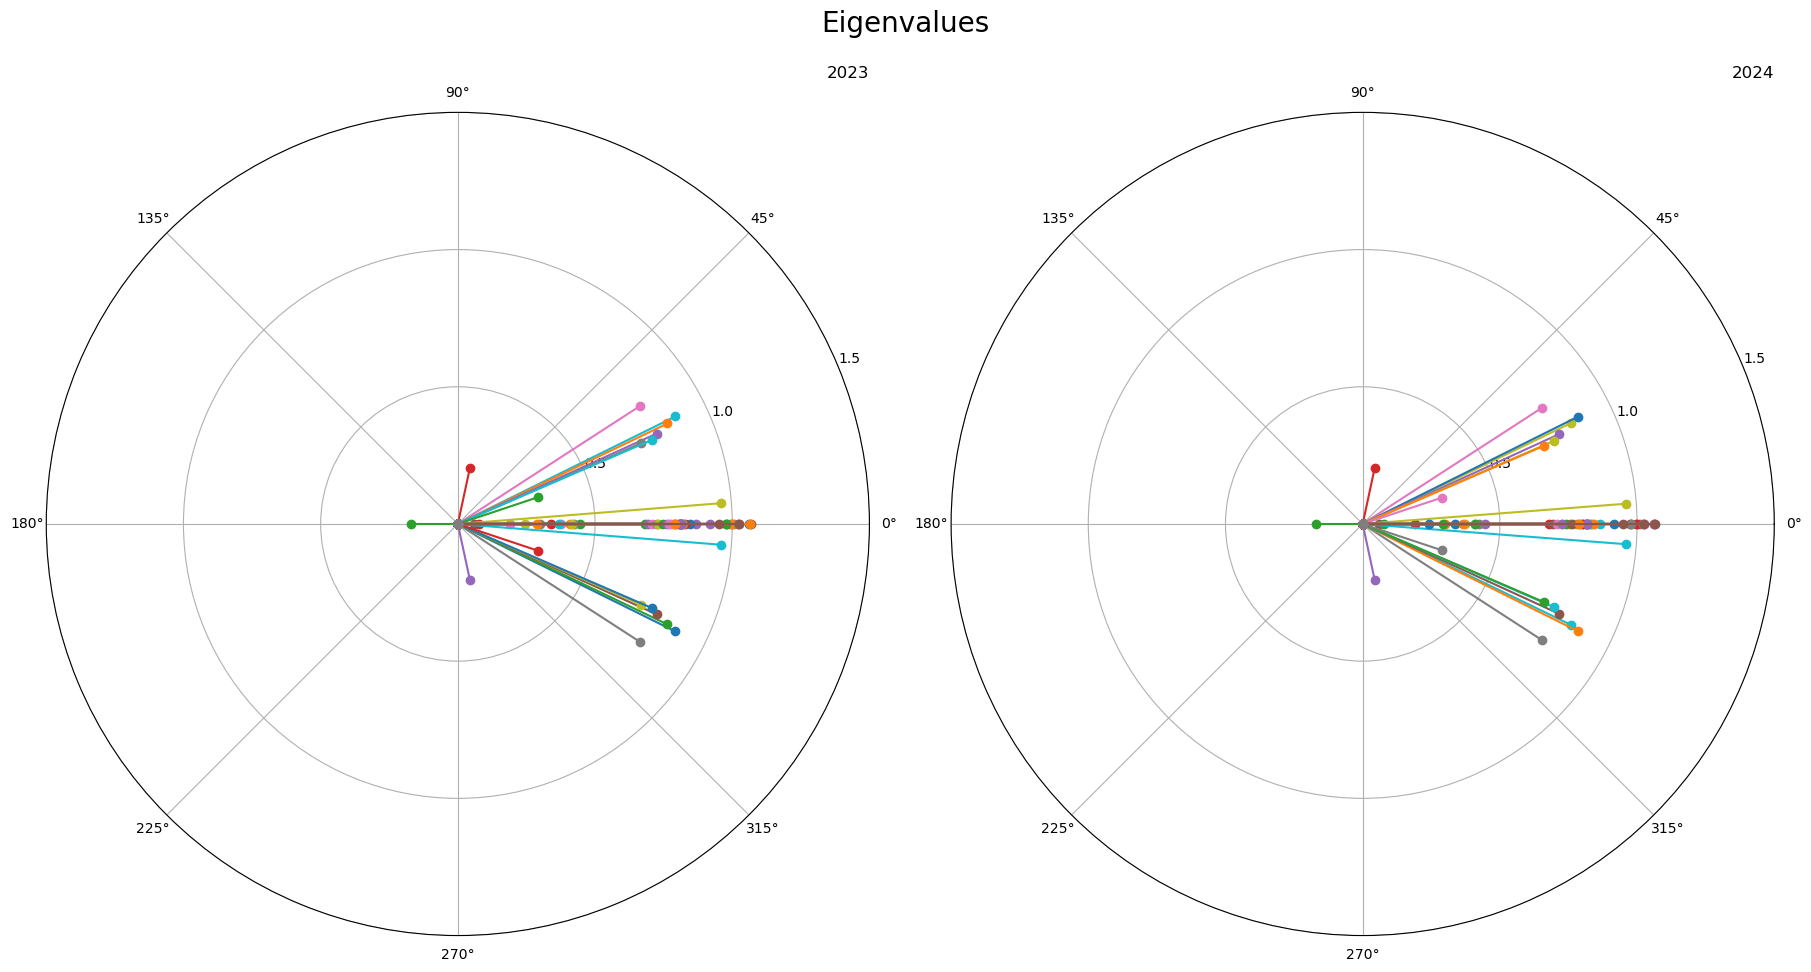

In [11]:
mpak_newton.eigplot_all(xx,size=(3,3));

In [12]:
eigen = xx[2023]
gt1_no_imag = sorted([(ii,i)  for ii,i in enumerate(eigen) if abs(i) >= 1 and abs(i.imag) < 0.0000000001],reverse=True)
gt1_imag    = sorted([(ii,i)  for ii,i in enumerate(eigen) if np.abs(i) >= 1 and np.abs(i.imag) >  0.00000001],reverse=True)

print('Eigenvalues with length above 1 and only real: ')
print(*[f'element {ii} length: {abs(i):.5f} ' for ii,i in gt1_no_imag],'  ',sep='\n')
print('Eigenvalues with length above 1 and imaginary: ')
print(*[f'element {ii} length: {abs(i):.5f} {i.real:.5f} {i.imag:.5f}' for ii,i in gt1_imag],sep='\n')

Eigenvalues with length above 1 and only real: 
element 1435 length: 1.02441 
element 1347 length: 1.02000 
element 1241 length: 1.06368 
element 1240 length: 1.06038 
element 1235 length: 1.06684 
element 587 length: 1.00816 
element 546 length: 1.02299 
  
Eigenvalues with length above 1 and imaginary: 




<p>
<div class="warning" style='padding:0.1em; background-color:#E9D8FD; color:#69337A'>

<p style='margin-top:1em; text-align:center'>
<b>Box:Exogenizing Endogenous variables</b></p>
<p style='margin-left:1em;'>

In WB models using modelflow each endogenous equation is written in the following form


    y=(f(stuff +y_AF)*(1-y_D)+y_D*y_X


Thus there are three variables in the model for each endogenous variable
  
    y   : the variable itself
    y_D : a dummy variable set to 1 when the equation has been exogenized
    y_X : a variable that represents the exogenized value that the equation should resolve to if exogenized
    y_AF: An add factor used to shift the result of an eqyation by a specific amount.
    
Thus if D=0 (the equation i turned on), the model will resolve to

    y=f(stuff)+y_X

if D=1 then the equation has been exogenized (turned off) and it will resolve to:

    y=y_X

<p style='margin-top:1em; text-align:center'>
<b>End of Box</b></p>    

</div>

### Impact on the 20 largest eigenvalue from dropping equations 
The largest eigenvalues are hardly impacted

In [13]:

xx = mpak_newton.get_eigen_jackknife_abs_select(2023,largest = 20)
xx.plot(kind='hist',bins=40)
pd.concat([xx.head(),xx.loc[['ALL']],xx.tail()])

Calculating eigenvalues of 287 different matrices takes time, so make cup of coffee and a take a short nap
Using reserve calculatioon of eigenvalues dropvar_nr=243 dropvar='PAKNYYGOSOTLCN'


AttributeError: 'numpy.ndarray' object has no attribute 'toarray'

### Impact on the 100 largest eigenvalue from dropping equations 

In [ ]:

xx = mpak_newton.get_eigen_jackknife_abs_select(2023,maxnames=500,largest = 100)
xx.plot(kind='hist',bins=40)
pd.concat([xx.head(),xx.loc[['ALL']],xx.tail()])

## Next step, modify an equation 
Ideas please 

In [34]:
%load_ext autoreload
%autoreload 2

In [36]:
eigendic = mpak_newton.get_eigen_jackknife(maxnames=5)

Calculating eigenvalues of 302 different matrices takes time, so make cup of coffee and a take a short nap


In [15]:
eigendic

{'ALL': {2023: array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  2024: array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 'CHNEXR05_excluded': {2023: array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  2024: array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 'CHNPCEXN05_excluded': {2023: array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  2024: array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 'DEUEXR05_excluded': {2023: array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  2024: array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 'DEUPCEXN05_excluded': {2023: array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  2024: array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 'FRAEXR05_excluded': {2023: array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]),
  2024: array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 'FRAPCEXN05_excluded': {2023: array([

In [19]:
import pandas as pd

# Sample data (shortened for demonstration)
data = eigendic

# Flattening the dictionary and preparing data for DataFrame
flattened_data = []
for scenario, years in data.items():
    for year, values in years.items():
        for i, value in enumerate(values):
            flattened_data.append({'Scenario': scenario, 'Year': year, 'Index': i, 'Value': value})

# Creating the DataFrame
df = pd.DataFrame(flattened_data)
df['Real'] = df['Value'].apply(lambda x: x.real)
df['Imag'] = df['Value'].apply(lambda x: x.imag)

# Display the DataFrame
print(df)


                      Scenario  Year  Index                            Value  \
0                          ALL  2023      0 0.0000000000000+0.0000000000000j   
1                          ALL  2023      1 0.0000000000000+0.0000000000000j   
2                          ALL  2023      2 0.0000000000000+0.0000000000000j   
3                          ALL  2023      3 0.0000000000000+0.0000000000000j   
4                          ALL  2023      4 0.0000000000000+0.0000000000000j   
...                        ...   ...    ...                              ...   
63339  PAKBNCABFUNDCN_excluded  2024   1503 0.0000000000000+0.0000000000000j   
63340  PAKBNCABFUNDCN_excluded  2024   1504 0.0000000000000+0.0000000000000j   
63341  PAKBNCABFUNDCN_excluded  2024   1505 0.0000000000000+0.0000000000000j   
63342  PAKBNCABFUNDCN_excluded  2024   1506 0.0000000000000+0.0000000000000j   
63343  PAKBNCABFUNDCN_excluded  2024   1507 0.0000000000000+0.0000000000000j   

                 Real            Imag  

In [28]:
df.query('Scenario == "ALL" & Year == 2024').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1512 entries, 1512 to 3023
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype     
---  ------    --------------  -----     
 0   Scenario  1512 non-null   object    
 1   Year      1512 non-null   int64     
 2   Index     1512 non-null   int64     
 3   Value     1512 non-null   complex128
 4   Real      1512 non-null   float64   
 5   Imag      1512 non-null   float64   
dtypes: complex128(1), float64(2), int64(2), object(1)
memory usage: 94.5+ KB
